# Ensemble methods

Натренувати класифікатори на датасеті

https://archive.ics.uci.edu/dataset/603/in+vehicle+coupon+recommendation

Мають бути 3 варіанти класифікаторів (стекінг, бустінг, беггінг)

In [63]:
# Підключаємо Google Drive з датасетами
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
# Імпортуємо всі необхідні бібліотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set()

%config InlineBackend.figure_format = "png"

# зчитуємо набір даних
datasets_path = "/content/drive/MyDrive/Colab Notebooks/in_vehicle_coupon_recommendation/"
df = pd.read_csv(datasets_path + "in-vehicle-coupon-recommendation.csv")

In [65]:
!pip install category_encoders xgboost catboost lightgbm

# Аналіз датасету

In [66]:
# Проведемо первинний аналіз даних датасету
print("Загальний опис датасету:")
df.info()

Загальний опис датасету:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar        

In [67]:
# Чи є пусті значення?
print(df.isna().sum(), "\n")

destination                 0
passanger                   0
weather                     0
temperature                 0
time                        0
coupon                      0
expiration                  0
gender                      0
age                         0
maritalStatus               0
has_children                0
education                   0
occupation                  0
income                      0
car                     12576
Bar                       107
CoffeeHouse               217
CarryAway                 151
RestaurantLessThan20      130
Restaurant20To50          189
toCoupon_GEQ5min            0
toCoupon_GEQ15min           0
toCoupon_GEQ25min           0
direction_same              0
direction_opp               0
Y                           0
dtype: int64 



Бачимо, що у деяких колонках є велика кількість пустих значень.

In [68]:
# Перевіряємо чи є дублікати
df.duplicated().sum()

74

Датасет має 26 колонок - 25 фіч і таргет. Є пусті значення та дублікати.



In [69]:
# Бачимо, що фіча car має дуже багато пустих значень, тож можемо її видалити, бо вона нам не приносить ніякої користі
df = df.drop(columns="car")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  Bar                   12577 non-null  object
 15  CoffeeHouse           12467 non-null

In [70]:
# Тепер виконаємо перетворення типів даних для деяких фіч.
df = df.astype(
    {
        "temperature": "int16",
        "has_children": "int8",
        "toCoupon_GEQ5min": "int8",
        "toCoupon_GEQ15min": "int8",
        "toCoupon_GEQ25min": "int8",
        "direction_same": "int8",
        "direction_opp": "int8",
        "Y": "int8",
    },
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int16 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int8  
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  Bar                   12577 non-null  object
 15  CoffeeHouse           12467 non-null

In [71]:
# Подивимось на значення фічей
df["toCoupon_GEQ5min"].value_counts()

1    12684
Name: toCoupon_GEQ5min, dtype: int64

In [72]:
# Фіча toCoupon_GEQ5min має тільки одне значення. Можемо її видалити, бо така фіча не потрібна для тренування.
df = df.drop(columns="toCoupon_GEQ5min")

In [73]:
# Розмір датасету дозволяє нам прибрати частину фічей з NaN значеннями
df = df.dropna()

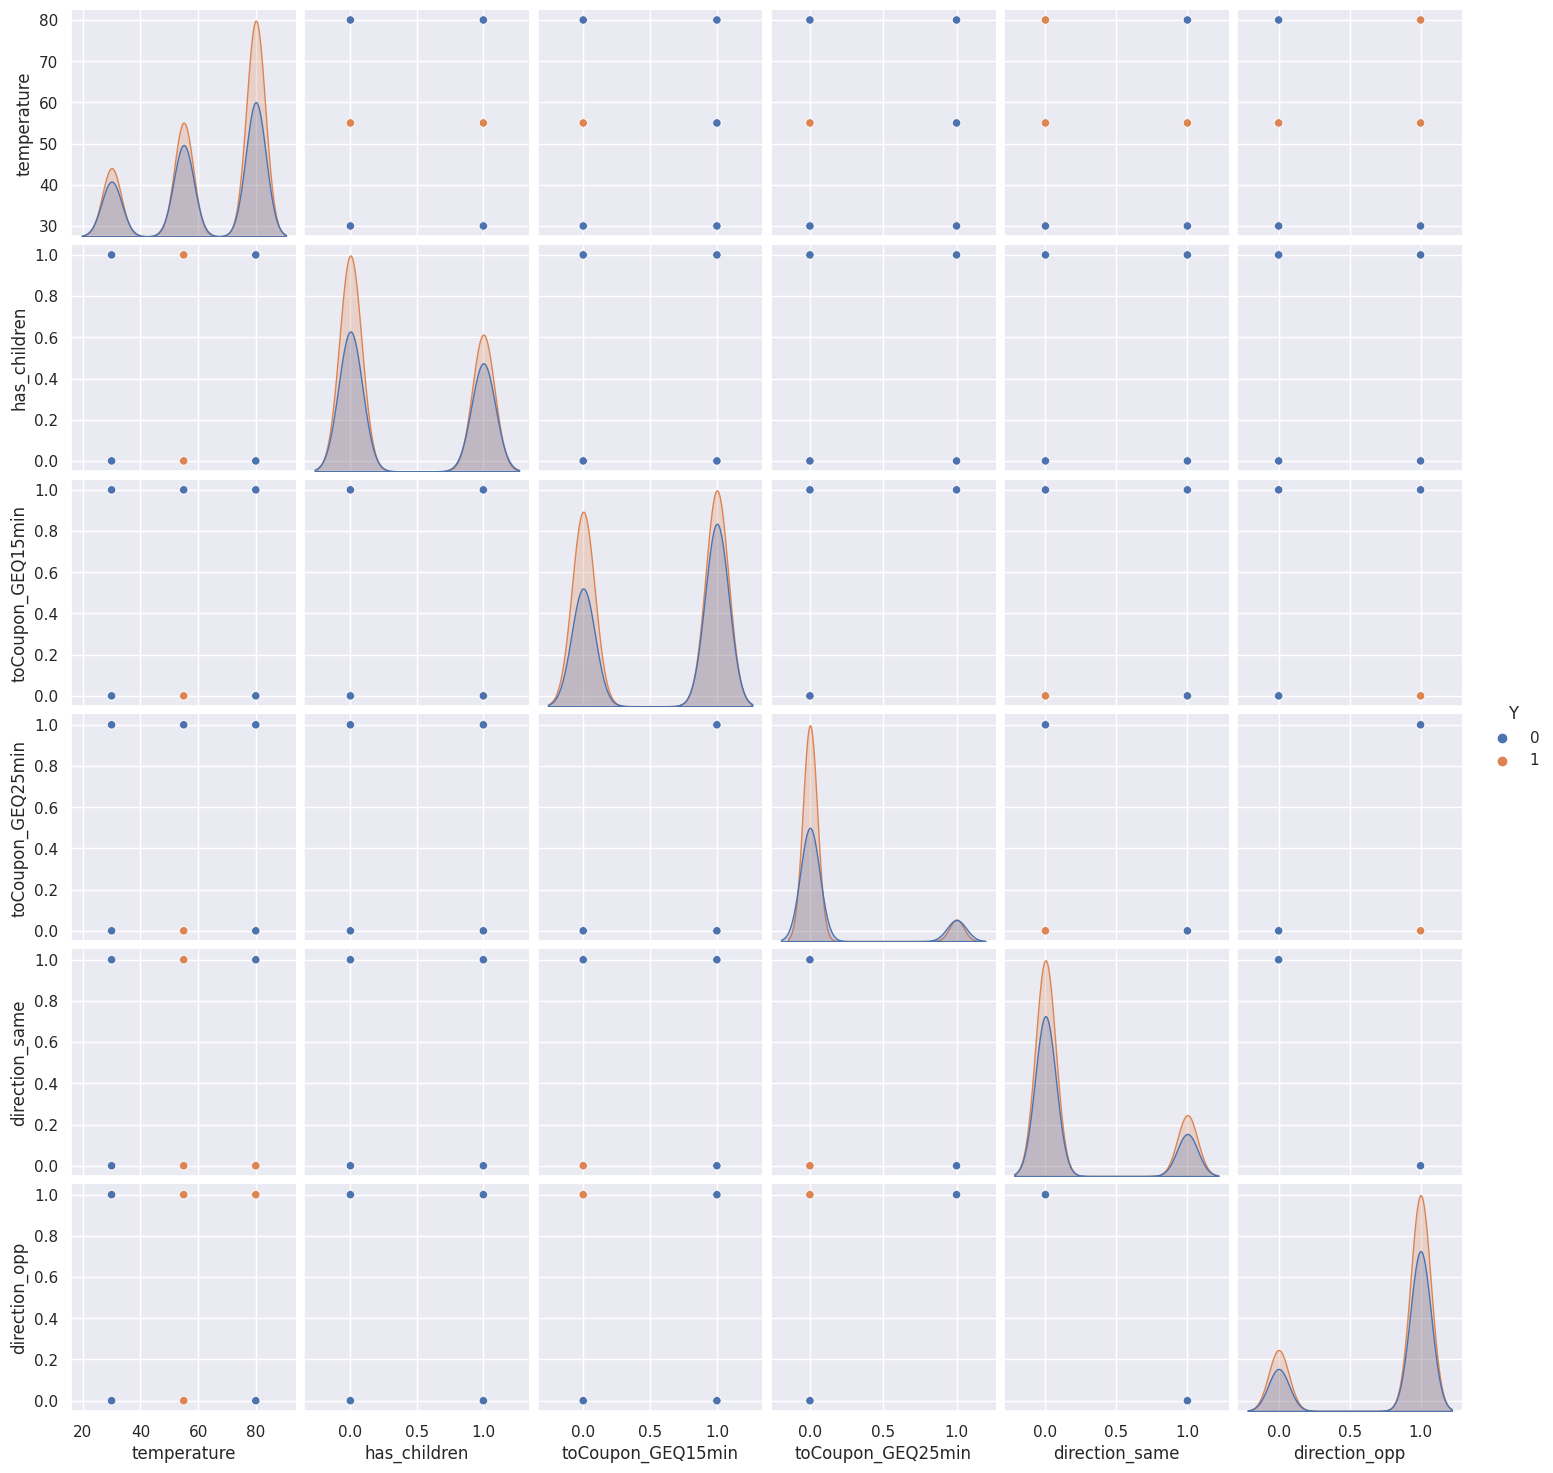

In [43]:
# Тепер можем подивитись на кореляцію числових фіч
sns.pairplot(df, hue="Y");

Ці фічі в датасеті не корелюють, але давайте ще подивимось на хітмап.

<ipython-input-44-8c1598bec9d1>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


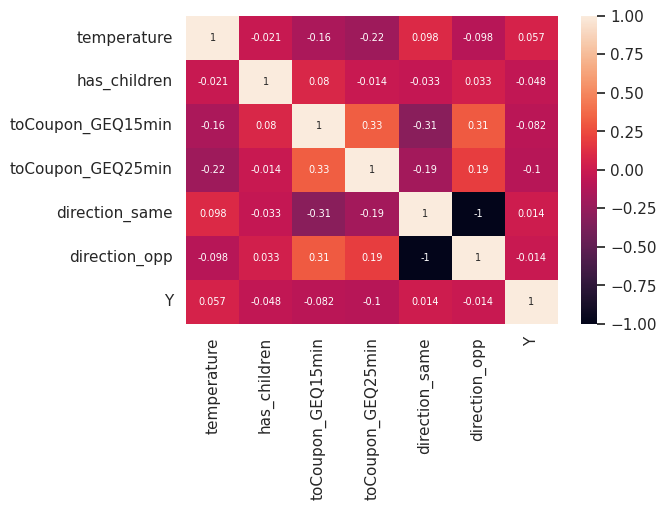

In [44]:
# Побудуємо хітмап
plt.figure(figsize = (6, 4))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize": 7});

Згідно хітмпапи можемо впевнитись, що ці фічі між собою не корелюють.

<Axes: >

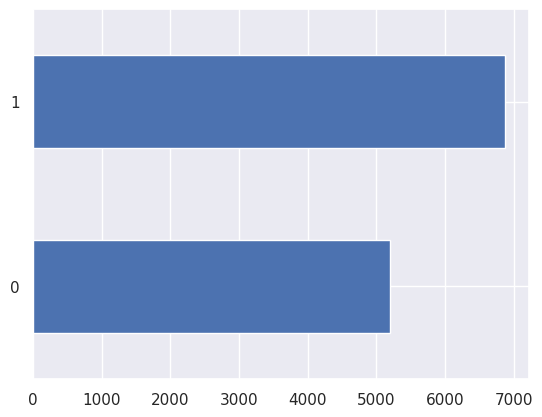

In [45]:
# Подивимось розподіл датасету по таргету
df["Y"].value_counts(ascending=True).sort_index().plot(kind="barh")

По таргету бачимо, що даних классу `1` представлено десь на 25% більше, ніж даних классу 0. Для покращення якості моделей після енкодінгу категоріальних фічей можно спробувати зробити undersampling балансування. В цій роботі ми це роботи не будемо, але маємо це на увазі.

# Feature engineering

In [74]:
# Зробимо квадрат температури
df["temperature_pow"] = df["temperature"] ** 2
df = df.drop(columns=["temperature"])

In [75]:
# Колонки direction_same та direction_opp наче описують одну і ту
# саму інформацію у вигляді бінарної матриці, тож фактично можемо скласти значення і видалити одну з колонок.
df["direction_same"] = df["direction_same"] + df["direction_opp"]
df = df.drop(columns=["direction_opp"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12079 entries, 22 to 12683
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12079 non-null  object
 1   passanger             12079 non-null  object
 2   weather               12079 non-null  object
 3   time                  12079 non-null  object
 4   coupon                12079 non-null  object
 5   expiration            12079 non-null  object
 6   gender                12079 non-null  object
 7   age                   12079 non-null  object
 8   maritalStatus         12079 non-null  object
 9   has_children          12079 non-null  int8  
 10  education             12079 non-null  object
 11  occupation            12079 non-null  object
 12  income                12079 non-null  object
 13  Bar                   12079 non-null  object
 14  CoffeeHouse           12079 non-null  object
 15  CarryAway             12079 non-nul

Тепер зробимо окремий датасет з енкодінгом категоріальних фічей, щоб мати можливість порівняти як енкодінг вплине на результат роботи моделей.

# Енкодінг фічей

In [76]:
from sklearn.preprocessing import LabelEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.m_estimate import MEstimateEncoder

# Робимо повну копію з оригінального датасету
df_enc = df.copy(deep=True)

# Частину фічей енкодимо за допомогою LabelEncoder
le = LabelEncoder()

for x in ["passanger", "destination", "expiration", "gender", "weather"]:
  df_enc[x] = le.fit_transform(df_enc[x])

# Ще частину через CatBoostEncoder
cat_boost = CatBoostEncoder(cols=["occupation", "CoffeeHouse", "CarryAway", "RestaurantLessThan20"])
df_enc = cat_boost.fit_transform(df_enc, df_enc["Y"])

# Ще частину через JamesSteinEncoder
js = JamesSteinEncoder(cols=["education", "income", "Bar", "Restaurant20To50"])
df_enc = js.fit_transform(df_enc, df_enc["Y"])

# І останню частину фічей енкодимо через MEstimateEncoder
me = MEstimateEncoder(cols=["time", "coupon", "maritalStatus", "age"])
df_enc = me.fit_transform(df_enc, df_enc["Y"])

In [77]:
df_enc.head()

,destination,passanger,weather,time,coupon,expiration,gender,age,maritalStatus,has_children,...,Bar,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,Y,temperature_pow
22,1,0,2,0.660704,0.708956,0,1,0.593999,0.610279,0,...,0.539001,0.569335,0.569335,0.569335,0.561184,0,0,1,1,3025
23,1,1,2,0.607952,0.496350,1,1,0.593999,0.610279,0,...,0.539001,0.784668,0.784668,0.784668,0.561184,0,0,1,0,6400
24,1,1,2,0.607952,0.412001,0,1,0.593999,0.610279,0,...,0.539001,0.523112,0.523112,0.523112,0.561184,0,0,1,1,6400
25,1,1,2,0.607952,0.737645,1,1,0.593999,0.610279,0,...,0.539001,0.642334,0.642334,0.642334,0.561184,1,0,1,0,6400
26,1,1,2,0.660704,0.496350,0,1,0.593999,0.610279,0,...,0.539001,0.513867,0.513867,0.513867,0.561184,0,0,1,0,6400


# Аналіз датасету після енкодінга категоріальних фічей

Побудуємо pairplot і хітмап, щоб подивитись на кореляцію всіх фічей.

In [50]:
sns.pairplot(df_enc, hue="Y");

Output hidden; open in https://colab.research.google.com to view.

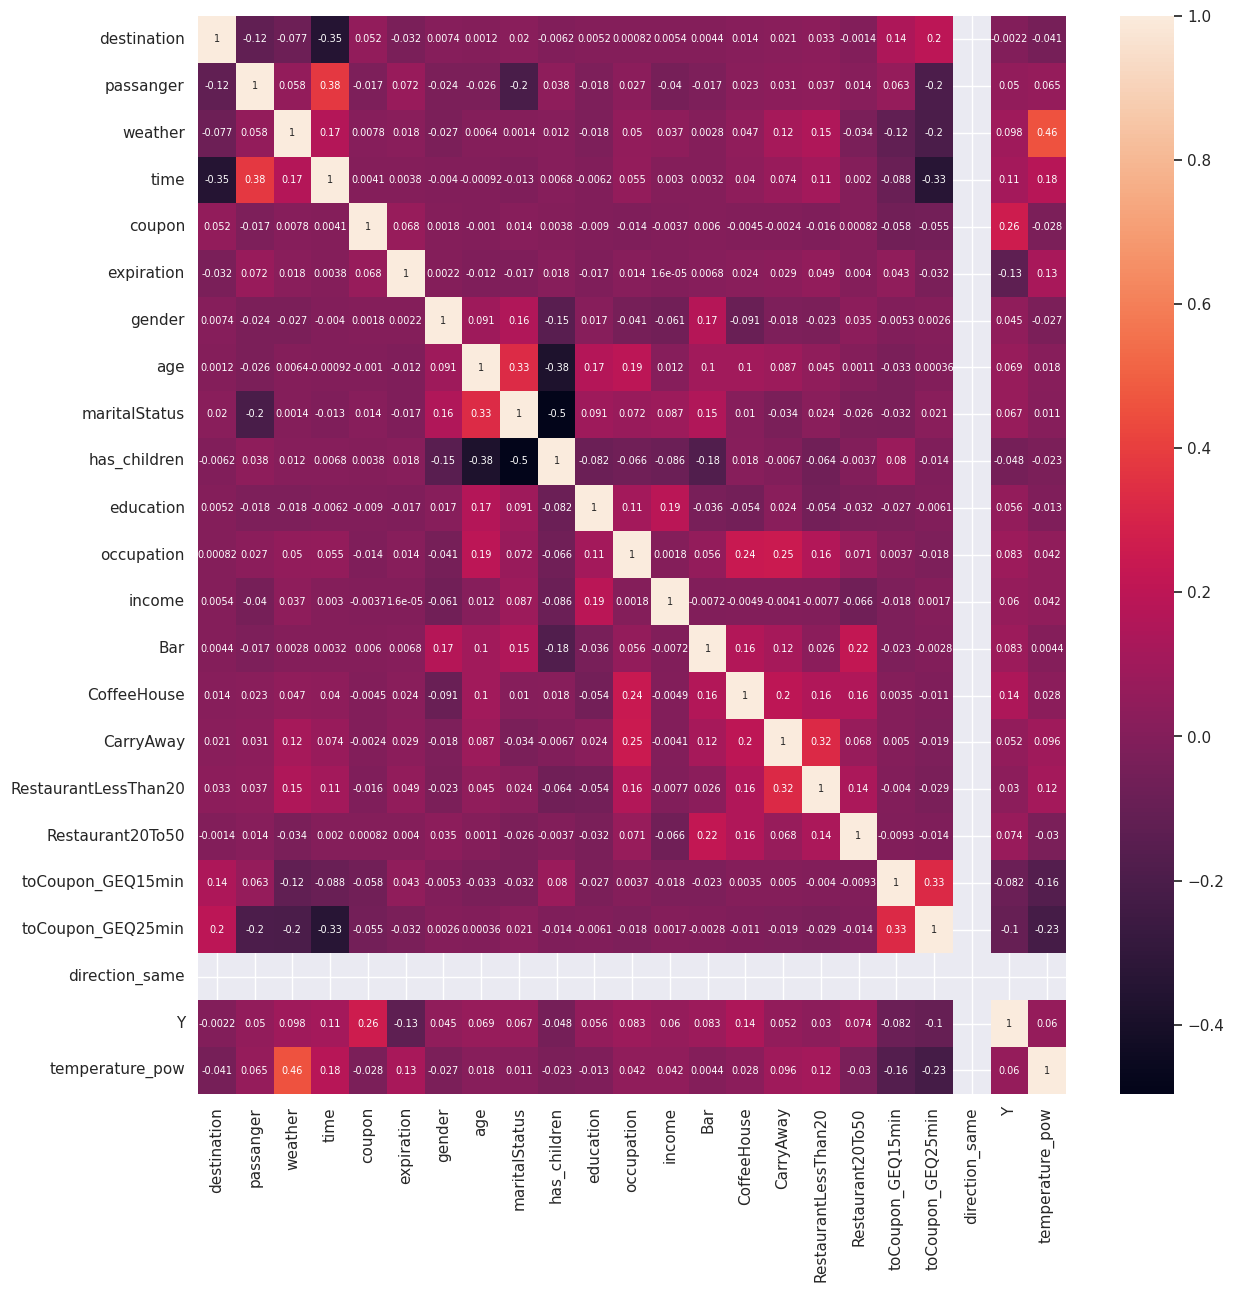

In [51]:
# Побудуємо хітмап
plt.figure(figsize = (14, 14))
corr_matrix = df_enc.corr()
sns.heatmap(corr_matrix, annot=True, annot_kws={"fontsize": 7});

Бачимо, що фічі між собою не корелюють. Можемо переходити до тренування моделей.

# Тренування моделей

In [78]:
# Розбиваємо датасети на X та Y
X = df.drop(columns="Y")  # фічі
X_enc = df_enc.drop(columns="Y")
Y = df["Y"]  # таргет

In [79]:
# Зробимо масштабування фіч використовуючи MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_enc = scaler.fit_transform(X_enc)

In [80]:
# Ділимо датасет на тренувальну, валідаційну та тестові частини за схемою 60-20-20
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

x_train, x_rem, y_train, y_rem = train_test_split(X, Y, train_size=0.6, random_state=42, stratify=Y)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size=0.5, random_state=42, stratify=y_rem)

x_train_enc, x_rem_enc, y_train_enc, y_rem_enc = train_test_split(X_enc, Y, train_size=0.6, random_state=42, stratify=Y)
x_valid_enc, x_test_enc, y_valid_enc, y_test_enc = train_test_split(x_rem_enc, y_rem_enc, test_size=0.5, random_state=42, stratify=y_rem_enc)

In [81]:
# Спочатку побудуємо модель логістичної регресії. Вона не буде працювати з категоріальними фічами, тож одразу перевіряємо її на датасеті, якому робили енкодінг.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error

grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        "fit_intercept": [True, False],
        "intercept_scaling": [1, 2, 5, 10],
        "multi_class": ["auto", "ovr", "multinomial"],
    },
)
grid_search.fit(x_valid_enc, y_valid_enc)

print("Результати тюнінгу гіперпараметрів для LinearRegression:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
grid_search.best_estimator_.fit(x_train_enc, y_train_enc)
predict = grid_search.best_estimator_.predict(x_test_enc)

# Значення середньоквардатичної похибки
print("Результати тренування моделі:")
print(
    "Середньоквадратична похибка:",
    mean_squared_error(y_test, predict),
)
# Подивимось на точність моделі на тестових даних
print(
    "Точність моделі на тестових даних:",
    grid_search.best_estimator_.score(x_test_enc, y_test_enc) * 100,
)

Результати тюнінгу гіперпараметрів для LinearRegression: 

Найкращі параметри: {'fit_intercept': True, 'intercept_scaling': 1, 'multi_class': 'multinomial'}
Найкращий score: 0.6891603784884418 

Результати тренування моделі:
Середньоквадратична похибка: 0.3307119205298013
Точність моделі на тестових даних: 66.92880794701986


Логістична регресія вже показує результат на цих даних, тож спробуємо ще побудувати звичайне рішальне дерево, а потім порівняємо результати з ансамблями.

In [82]:
# Будуємо DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid={
        "criterion": ["gini", "entropy", "log_loss"],
        "splitter": ["best", "random"],
        "max_depth": [None, 10, 20, 50, 100, 1000],
        "min_samples_split": [2, 10, 20, 50, 100],
        "min_samples_leaf": [1, 10, 25, 50, 100],
        "min_weight_fraction_leaf": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5],
        "random_state": [42],
    },
)
grid_search.fit(x_valid_enc, y_valid_enc)

print("Результати тюнінгу гіперпараметрів для DecisionTreeClassifier:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
dt_model = grid_search.best_estimator_
dt_model.fit(x_train_enc, y_train_enc)
predict = dt_model.predict(x_test_enc)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test_enc, predict))

Результати тюнінгу гіперпараметрів для DecisionTreeClassifier: 

Найкращі параметри: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 25, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'random'}
Найкращий score: 0.6908089933781634 

Результати тренування моделі:
              precision    recall  f1-score   support

           0       0.63      0.59      0.61      1041
           1       0.71      0.74      0.72      1375

    accuracy                           0.68      2416
   macro avg       0.67      0.67      0.67      2416
weighted avg       0.67      0.68      0.67      2416



DecisionTreeClassifier показує посередні результати, тож спробуємо використати ансамблі для більш кращої класифікації.

# Bagging

In [83]:
# Тепер побудуємо RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid={
        "n_estimators": [100, 200, 500],
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": [None, 5, 10, 20, 50],
        "bootstrap": [True, False],
        "oob_score": [True, False],
        "random_state": [42],
        "warm_start": [True, False],
    },
)
grid_search.fit(x_valid_enc, y_valid_enc)

print("Результати тюнінгу гіперпараметрів для RandomForestClassifier:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
rf_model = grid_search.best_estimator_
rf_model.fit(x_train_enc, y_train_enc)
predict = rf_model.predict(x_test_enc)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test_enc, predict))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
450 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
450 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 434, in fit
    raise ValueError("Out of bag estimation only available if bootstrap=True")
ValueError: Out of bag estimation only available if bootstrap=True

  warnings.warn(some_fits_failed_message, FitFailedWarning)
/usr/local

Результати тюнінгу гіперпараметрів для RandomForestClassifier: 

Найкращі параметри: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 100, 'oob_score': False, 'random_state': 42, 'warm_start': True}
Найкращий score: 0.7144106223157607 

Результати тренування моделі:
              precision    recall  f1-score   support

           0       0.66      0.60      0.63      1041
           1       0.72      0.77      0.74      1375

    accuracy                           0.70      2416
   macro avg       0.69      0.69      0.69      2416
weighted avg       0.69      0.70      0.69      2416



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:452: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


In [90]:
# Також спробуємо BaggingClassifier
from sklearn.ensemble import BaggingClassifier

grid_search = GridSearchCV(
    estimator=BaggingClassifier(),
    param_grid={
        "n_estimators": [100, 200, 500],
        "max_samples": [None, 0, 0.1, 0.2, 0.5, 1],
        "max_features": [1, 2, 5, 10, 20],
        "bootstrap": [True, False],
        "oob_score": [True, False],
        "warm_start": [True, False],
        "random_state": [42],
    },
)
grid_search.fit(x_valid_enc, y_valid_enc)

print("Результати тюнінгу гіперпараметрів для BaggingClassifier:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
bc_model = grid_search.best_estimator_
bc_model.fit(x_train_enc, y_train_enc)
predict = bc_model.predict(x_test_enc)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test_enc, predict))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2100 fits failed out of a total of 3600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
600 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py", line 326, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn

Результати тюнінгу гіперпараметрів для BaggingClassifier: 

Найкращі параметри: {'bootstrap': True, 'max_features': 20, 'max_samples': 0.5, 'n_estimators': 500, 'oob_score': True, 'random_state': 42, 'warm_start': False}
Найкращий score: 0.7044701675136459 

Результати тренування моделі:
              precision    recall  f1-score   support

           0       0.74      0.64      0.68      1041
           1       0.75      0.83      0.79      1375

    accuracy                           0.75      2416
   macro avg       0.74      0.73      0.74      2416
weighted avg       0.75      0.75      0.74      2416



Iз ансамблів, що реалізують bagging, для цього датасету кращий результат показала модель BaggingClassifier.

# Boosting


In [91]:
# AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier

grid_search = GridSearchCV(
    estimator=AdaBoostClassifier(),
    param_grid={
        "n_estimators": [50, 100, 200, 500],
        "learning_rate": [1, 2, 5, 10],
        "algorithm": ["SAMME", "SAMME.R"],
        "random_state": [42],
    },
)
grid_search.fit(x_valid_enc, y_valid_enc)

print("Результати тюнінгу гіперпараметрів для AdaBoostClassifier:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
ada_boost_model = grid_search.best_estimator_
ada_boost_model.fit(x_train_enc, y_train_enc)
predict = ada_boost_model.predict(x_test_enc)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test_enc, predict))

Результати тюнінгу гіперпараметрів для AdaBoostClassifier: 

Найкращі параметри: {'algorithm': 'SAMME', 'learning_rate': 1, 'n_estimators': 200, 'random_state': 42}
Найкращий score: 0.6775704532621528 

Результати тренування моделі:
              precision    recall  f1-score   support

           0       0.64      0.57      0.60      1041
           1       0.70      0.76      0.73      1375

    accuracy                           0.68      2416
   macro avg       0.67      0.66      0.67      2416
weighted avg       0.67      0.68      0.67      2416



In [92]:
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

grid_search = GridSearchCV(
    estimator=GradientBoostingClassifier(),
    param_grid={
        "loss": ["log_loss", "exponential"],
        "learning_rate": [1, 2, 5, 10],
        "n_estimators": [100, 200, 500],
        "criterion": ["friedman_mse", "squared_error"],
        "max_depth": [3, 5, 10],
        "random_state": [42],
        "max_features": ["sqrt", "log2"],
        "warm_start": [False, True],
    },
)
grid_search.fit(x_valid_enc, y_valid_enc)

print("Результати тюнінгу гіперпараметрів для GradientBoostingClassifier:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
gr_boost_model = grid_search.best_estimator_
gr_boost_model.fit(x_train_enc, y_train_enc)
predict = gr_boost_model.predict(x_test_enc)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test_enc, predict))

Результати тюнінгу гіперпараметрів для GradientBoostingClassifier: 

Найкращі параметри: {'criterion': 'friedman_mse', 'learning_rate': 1, 'loss': 'log_loss', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500, 'random_state': 42, 'warm_start': False}
Найкращий score: 0.6920503738685557 

Результати тренування моделі:
              precision    recall  f1-score   support

           0       0.69      0.64      0.66      1041
           1       0.74      0.78      0.76      1375

    accuracy                           0.72      2416
   macro avg       0.71      0.71      0.71      2416
weighted avg       0.72      0.72      0.72      2416



In [93]:
# XGBoost не працює з категоріальними фічами, тож тренуємо одразу на датасеті з енкодінгом
from xgboost import XGBClassifier

grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid={
        "n_estimators": [2, 5, 10],
        "max_depth": [2, 6, 10, 20],
        "learning_rate": [1, 2, 5, 10],
    },
)
grid_search.fit(x_valid_enc, y_valid_enc)

print("Результати тюнінгу гіперпараметрів для XGBClassifier:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
xgboost_model = grid_search.best_estimator_
xgboost_model.fit(x_train_enc, y_train_enc)
predict = xgboost_model.predict(x_test_enc)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test_enc, predict))

Результати тюнінгу гіперпараметрів для XGBClassifier: 

Найкращі параметри: {'learning_rate': 1, 'max_depth': 6, 'n_estimators': 5}
Найкращий score: 0.6767517067912325 

Результати тренування моделі:
              precision    recall  f1-score   support

           0       0.67      0.64      0.66      1041
           1       0.74      0.76      0.75      1375

    accuracy                           0.71      2416
   macro avg       0.70      0.70      0.70      2416
weighted avg       0.71      0.71      0.71      2416



In [95]:
# CatBoost на датасеті без енкодінгу
from catboost import CatBoostClassifier

grid_search = GridSearchCV(
    estimator=CatBoostClassifier(
        cat_features=[
            "destination",
            "passanger",
            "weather",
            "time",
            "coupon",
            "expiration",
            "gender",
            "age",
            "maritalStatus",
            "education",
            "occupation",
            "income",
            "Bar",
            "CoffeeHouse",
            "CarryAway",
            "RestaurantLessThan20",
            "Restaurant20To50",
        ]
    ),
    param_grid={
        "depth": [4, 5, 6, 7, 8, 9, 10],
        "learning_rate": [0.01, 0.02, 0.03, 0.04],
        "iterations": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        "random_seed": [42],
        "logging_level": ["Silent"],
    },
)
grid_search.fit(x_valid, y_valid)

print("Результати тюнінгу гіперпараметрів для CatBoostClassifier:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
catboost_model = grid_search.best_estimator_
catboost_model.fit(x_train, y_train, plot=True)
predict = catboost_model.predict(x_test)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test, predict))

Результати тюнінгу гіперпараметрів для CatBoostClassifier: 

Найкращі параметри: {'depth': 8, 'iterations': 100, 'learning_rate': 0.03, 'logging_level': 'Silent', 'random_seed': 42}
Найкращий score: 0.7135816094314118 



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Результати тренування моделі:
              precision    recall  f1-score   support

           0       0.70      0.59      0.64      1041
           1       0.72      0.81      0.76      1375

    accuracy                           0.71      2416
   macro avg       0.71      0.70      0.70      2416
weighted avg       0.71      0.71      0.71      2416



In [96]:
# Подивимось, чи впливає енкодінг на результати моделі
catboost_model = CatBoostClassifier(
    depth=8,
    iterations=90,
    learning_rate=0.04,
    logging_level="Silent",
    random_seed=42,
)
catboost_model.fit(x_train_enc, y_train_enc, plot=True)
predict = catboost_model.predict(x_test_enc)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test_enc, predict))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Результати тренування моделі:
              precision    recall  f1-score   support

           0       0.72      0.59      0.65      1041
           1       0.73      0.82      0.77      1375

    accuracy                           0.72      2416
   macro avg       0.72      0.71      0.71      2416
weighted avg       0.72      0.72      0.72      2416



Так, бачимо що енкодінг для CatBoostClassifier трохи впливає на якість. Модель, що була натренована без енкодінгу показала accuracy 0.7, в той час як модель, що тренували на датасеті з енкодінгом - 0.72.

In [97]:
# LGBMClassifier може самостійно опрацьовувати категоріальні фічі тільки якщо вони
# присутні в датасеті з типом `category`. Тому для іксів потрібно виконати зміну типів.

categorical_features=[
    "destination",
    "passanger",
    "weather",
    "time",
    "coupon",
    "expiration",
    "gender",
    "age",
    "maritalStatus",
    "education",
    "occupation",
    "income",
    "Bar",
    "CoffeeHouse",
    "CarryAway",
    "RestaurantLessThan20",
    "Restaurant20To50",
]

cat_types = {f: "category" for f in categorical_features}

x_train_lgbm = x_train.astype(cat_types)
x_valid_lgbm  = x_valid.astype(cat_types)
x_test_lgbm  = x_test.astype(cat_types)

In [98]:
# LightGBM
from lightgbm import LGBMClassifier

grid_search = GridSearchCV(
    estimator=LGBMClassifier(),
    param_grid={
        "boosting_type": ["gbdt", "dart", "goss", "rf"],
        "num_leaves": [31, 35, 40, 45],
        "max_depth": [-1, 2, 5, 10, 20],
        "n_estimators": [100, 200, 500],
        "random_state": [42],
    },
)
grid_search.fit(x_valid_lgbm, y_valid)

print("Результати тюнінгу гіперпараметрів для LGBMClassifier:", "\n")
print("Найкращі параметри:", grid_search.best_params_,)
print("Найкращий score:", grid_search.best_score_, "\n")

# Навчаємо модель на тренувальних даних
lgbm_model = grid_search.best_estimator_
lgbm_model.fit(x_train_lgbm, y_train)
predict = lgbm_model.predict(x_test_lgbm)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test, predict))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
300 fits failed out of a total of 1200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
300 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/usr/lo

Результати тюнінгу гіперпараметрів для LGBMClassifier: 

Найкращі параметри: {'boosting_type': 'dart', 'max_depth': 5, 'n_estimators': 500, 'num_leaves': 35, 'random_state': 42}
Найкращий score: 0.7139914104340981 

Результати тренування моделі:
              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1041
           1       0.77      0.80      0.78      1375

    accuracy                           0.75      2416
   macro avg       0.74      0.74      0.74      2416
weighted avg       0.75      0.75      0.75      2416



In [99]:
# Давайте подивимось, чи вплинув енкодінг на роботу LightGBM
lgbm_model_enc = grid_search.best_estimator_
lgbm_model_enc.fit(x_train_enc, y_train_enc)
predict = lgbm_model_enc.predict(x_test_enc)

# Дивимось результати
print("Результати тренування моделі:")
print(classification_report(y_test_enc, predict))

Результати тренування моделі:
              precision    recall  f1-score   support

           0       0.73      0.63      0.67      1041
           1       0.74      0.83      0.78      1375

    accuracy                           0.74      2416
   macro avg       0.74      0.73      0.73      2416
weighted avg       0.74      0.74      0.74      2416



Для LGBMClassifier можно зробити висновок, що енкодінг не покращує модель, а навіть навпаки, деякі метрики погіршує. Например, recall для одно з значень таргету та f1-score погіршилися при використанні датасету з енкодінгом.

Загалом можемо побачити що з ансамблів, що реалізують бустінг, кращі результати для даного датасету показали CatBoostClassifier (з енкодінгом датасету) та LGBMClassifier (без енкодінга).

# Stacking

In [100]:
# StackingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier


estimators = [
    ("rf", RandomForestClassifier(max_depth=10, n_estimators=200, random_state=42)),
    ("gbc", GradientBoostingClassifier(n_estimators=100, random_state=42)),
    ("bgc", BaggingClassifier(random_state=42)),
    ("knn", KNeighborsClassifier(n_neighbors=5)),
    ("lgbm", LGBMClassifier(n_estimators=200)),
]

stacking_c = StackingClassifier(estimators=estimators)

# Навчаємо модель на тренувальних даних
stacking_c.fit(x_train_enc, y_train_enc)
predict = stacking_c.predict(x_test_enc)

# Дивимось результати
print("Результати тренування моделі StackingClassifier:")
print(classification_report(y_test_enc, predict))

Результати тренування моделі StackingClassifier:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70      1041
           1       0.76      0.83      0.79      1375

    accuracy                           0.75      2416
   macro avg       0.75      0.74      0.74      2416
weighted avg       0.75      0.75      0.75      2416



StackingClassifier показав найкращий результат. Тепер давайте подивимось на графічне представлення результаів роботи кращих моделей з усіх трьох видів ансамблів.

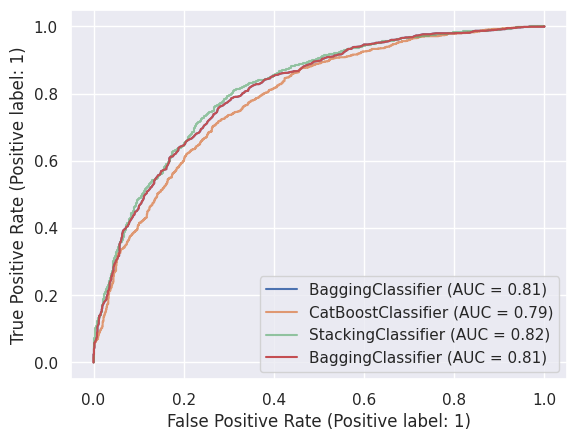

In [102]:
from sklearn.metrics import RocCurveDisplay

ax = plt.gca()

disp = RocCurveDisplay.from_estimator(bc_model, x_test_enc, y_test_enc, ax=ax, alpha=1)
cb_disp = RocCurveDisplay.from_estimator(catboost_model, x_test_enc, y_test_enc, ax=ax, alpha=0.8)
stacking_c_disp = RocCurveDisplay.from_estimator(stacking_c, x_test_enc, y_test_enc, ax=ax, alpha=0.6)
disp.plot(ax=ax)

Бачимо, що найкраще з усіх моделей с класифцікацією по цьому датасету впорався StackingClassifier, але класифікатори BaggingClassifier та CatBoostClassifier показали майже такий самий результат.

# Висновок
Ансамблі являють собою дуже потужний інструмент із класичного ML.
В цій роботі ми ознайомились на практиці із моделями ансамбів, що реалізують паттерни bagging, boosting та stacking. Також виявили, що для датасету, який використовувася в поточній роботі, найкраще підходить stacking ансамбль. Але цей результат можно спробувати покращити, використавши інший набор естімейторів.